# Implémentez un modèle de scoring

## SOMMAIRE

### [INTRODUCTION](#INTRODUCTION)
- [Contexte](#Contexte)
- [Objectifs](#Objectifs)

### [Notebook de Modélisation](#ETAPE-0-:-Notebook-de-modélisation)
- [1. Importation des Bibliothèques](#Importation-des-Bibliothèques)
- [2. Importation des données](#Importation-des-données)
- [3. Séparation des features et de la cible et train_test_split](#Séparation-des-features-et-de-la-cible)
- [4. Modèle **DummyClassifier** (baseline)](#DummyClassifier-(baseline))
- [5. Modèle **Régression Logistique** avec gestion du déséquilibre des classes)](#Modèle-**Régression-Logistique**-avec-gestion-du-déséquilibre-des-classes)
- [6. Modèle **RandomForest** avec gestion du déséquilibre des classes](#Modèle-**RandomForest**-avec-gestion-du-déséquilibre-des-classes)
- [7. Modèle **XGBoost** avec gestion du déséquilibre des classes](#Modèle-**XGBoost**-avec-gestion-du-déséquilibre-des-classes)
- [8. Modèle **LightGBM** avec gestion du déséquilibre des classes](#Modèle-**LightGBM**-avec-gestion-du-déséquilibre-des-classes)
- [9. Optimisation des hyperparamètres pour tous les modèles et Evaluation](#Optimisation-des-hyperparamètres)


# __________________________________________________________________________________________

# 1. Importation des Bibliothèques <a id="Importation-des-Bibliothèques"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import glob
import pickle
import os
import matplotlib.pyplot as plt
from pathlib import Path
import multiprocessing
import platform
import cpuinfo
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, auc
import os
import time
import mlflow
import mlflow.sklearn
import tempfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, classification_report,precision_recall_curve, confusion_matrix, precision_score, 
recall_score)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


In [2]:
import ipywidgets as widgets
widgets.IntSlider(description="Test")

IntSlider(value=0, description='Test')

In [3]:
# Nom du processeur
cpu = cpuinfo.get_cpu_info()
print("Nom du CPU :", cpu['brand_raw'])

# Nombre de cœurs logiques
print("Nombre de cœurs logiques :", multiprocessing.cpu_count())

Nom du CPU : 13th Gen Intel(R) Core(TM) i7-13620H
Nombre de cœurs logiques : 16


In [4]:
pd.set_option('display.max_columns', None) # pour afficher toutes les colonnes 
pd.set_option('display.max_rows', 100) # pour afficher 100 lignes

# __________________________________________________________________________________________

# 2. Importation des données <a id="Importation-des-données"></a>

In [7]:
# Chargement des datasets
data_train = pd.read_csv('data_train_final.zip', compression='zip', index_col=0)
data_test = pd.read_csv('data_test_final.zip', compression='zip', index_col=0)
TARGET = pd.read_csv('TARGET.csv', index_col=0).squeeze()  # squeeze pour récupérer une Series

In [8]:
data_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS,DAYS_EMPLOYED_ANOM,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT,PREV_APPL_MEAN_SK_ID_PREV,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_SK_ID_CURR,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT

In [9]:
data_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS,DAYS_EMPLOYED_ANOM,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT,PREV_APPL_MEAN_SK_ID_PREV,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_SK_ID_CURR,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT

In [14]:
# Vérification
print("Shape train:", data_train.shape)
print("Shape test:", data_test.shape)
print("Distribution TARGET:\n", TARGET.value_counts(normalize=True))

Shape train: (307511, 314)
Shape test: (48744, 313)
Distribution TARGET:
 TARGET
0.0    0.919271
1.0    0.080729
Name: proportion, dtype: float64


# 3. Séparation des features et de la cible et train_test_split <a id="Séparation-des-features-et-de-la-cible"></a>

* ### **Séparation - train_test_split**

In [21]:
X = data_train.drop("TARGET", axis=1)
y = data_train["TARGET"]

In [23]:
# Split en train/test pour évaluer
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [24]:
# Vérification des shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (246008, 313)
X_test: (61503, 313)
y_train: (246008,)
y_test: (61503,)


In [27]:
# Conversion des types pour économiser de la mémoire
for col in X_train.columns:
    if X_train[col].dtype == 'float64':
        X_train[col] = X_train[col].astype(np.float32)
    elif X_train[col].dtype == 'int64':
        X_train[col] = X_train[col].astype(np.int32)

***

In [30]:
# Fonction de coût métier
def cout_metier(y_true, y_pred, cout_FN=10, cout_FP=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * cout_FN + fp * cout_FP

# Fonction pour trouver le meilleur seuil selon le coût métier
def find_best_threshold(y_true, y_proba, cout_FN=10, cout_FP=1):
    thresholds = np.linspace(0, 1, 100)
    best_cost = float('inf')
    best_threshold = 0.5  # seuil par défaut
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cost = cout_metier(y_true, y_pred, cout_FN=cout_FN, cout_FP=cout_FP)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    return best_threshold

`def cout_metier` : 
* Prend en compte le déséquilibre des coûts : Le coût des faux négatifs (FN) est pondéré par un facteur 10, conformément aux consignes du projet (FN = 10 x FP).
* Utilise la matrice de confusion : Récupère les FP et FN directement, ce qui est optimal pour ce type de calcul.


`def find_best_threshold` : 
* Optimisation du Seuil : Explore 100 valeurs de seuil entre 0 et 1 pour trouver celui qui minimise le coût métier, ce qui répond précisément aux consignes du projet d'optimisation du seuil.
* Prend en compte le déséquilibre des coûts : Utilise directement cout_metier() pour intégrer les coûts asymétriques.
* Renvoie le meilleur seuil : Retourne le seuil optimal.

# 4. Modèle **DummyClassifier** (baseline) <a id="DummyClassifier-(baseline)"></a>

* Pas de gestion du déséquilibre ici, c’est un modèle de base qui sert uniquement de référence naïve. Il prédit toujours la classe majoritaire.
* Utilisé pour avoir un score plancher.

In [23]:
model = DummyClassifier(strategy="most_frequent")
model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

* ### **Évaluation avec seuil par défaut (0.5)**

In [25]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.5
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

Matrice de confusion (seuil 0.5):
 [[56538     0]
 [ 4965     0]]


C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 Coût métier (seuil 0.5) : 49650


* ### **Optimisation du seuil selon le coût métier**

Seuil optimisé pour le coût métier : 0.010
Coût métier minimal : 49650


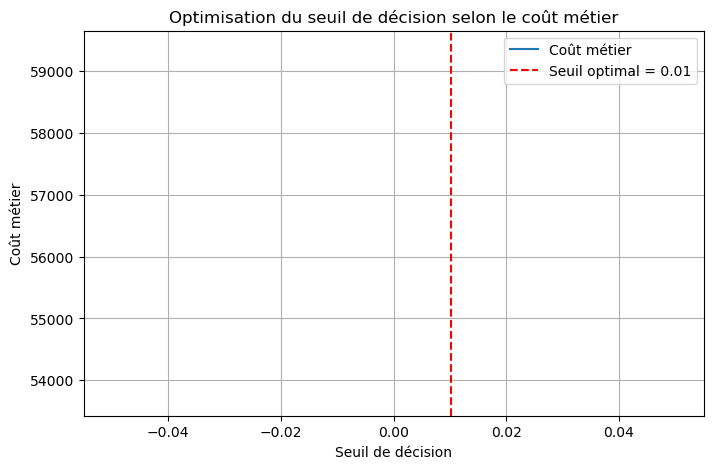

In [27]:
# Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

**Score métier personnalisé :**
* Nous avons bien implémenté une fonction de coût métier en pondérant les FN 10 fois plus que les FP.
* Nous avons cherché le seuil optimal sur la probabilité de sortie du modèle en fonction de ce coût.
* L'objectif : optimiser le seuil ≠ 0.5.

* ## **Réévaluation avec le seuil optimisé**

In [30]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[56538     0]
 [ 4965     0]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* Les résultats montrent que DummyClassifier ne prédit aucun défaut (classe 1.0), même avec le seuil optimisé.
    * Problème de déséquilibre des classes : TARGET est fortement déséquilibré : 92% de non-défaut (0). Le modèle "most_frequent" prédit toujours la classe majoritaire (0), donc aucun défaut détecté.

    * Impact sur les métriques : Recall (rappel) pour les défauts (1.0) est de 1.00 avec le seuil optimisé, car le seuil 0.000 force toutes les prédictions en 1. Precision est de 0.00, extrêmement faible, car tout est classé comme défaut.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

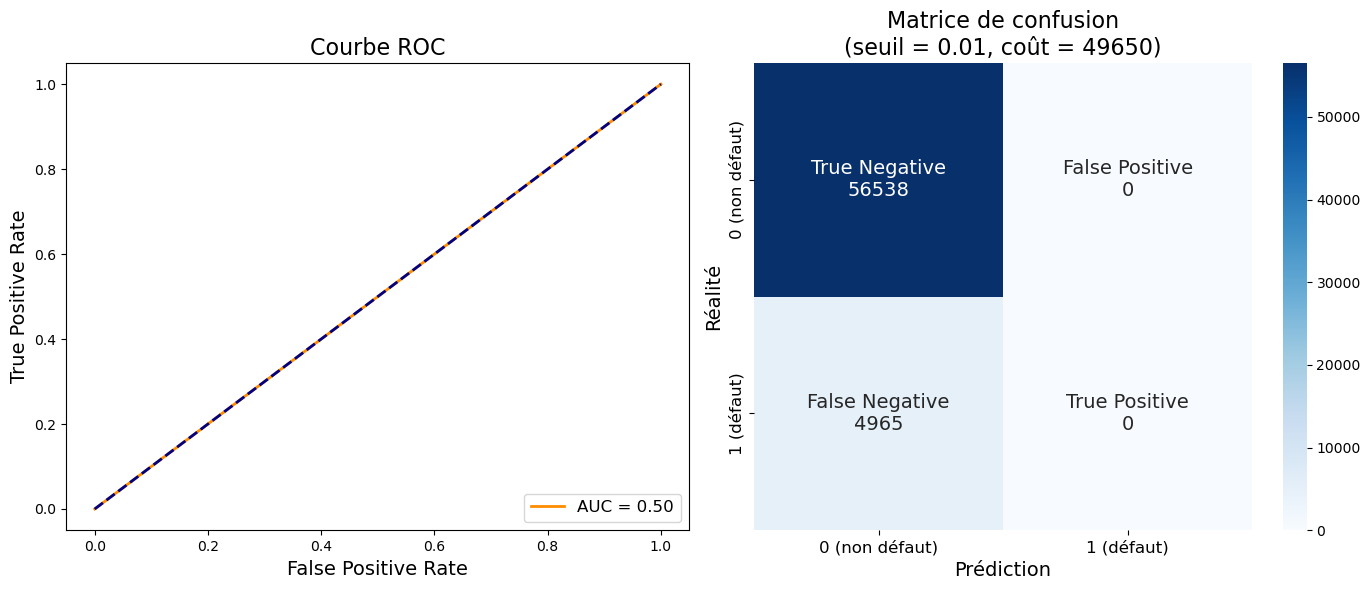

In [33]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* Vrais négatifs (TN) : 56,538 - Prédits comme négatifs, étaient effectivement négatifs.
* Faux positifs (FP) : 0 - Prédits comme positifs, étaient en réalité négatifs (aucune erreur ici).
* Faux négatifs (FN) : 4,965 - Prédits comme négatifs, étaient en réalité positifs (problème ici).
* Vrais positifs (TP) : 0 - Prédits comme positifs, étaient effectivement positifs (aucun vrai positif détecté).

**Le modèle n'a identifié aucun cas positif, ce qui signifie que tous les vrais positifs ont été classés comme négatifs, même après optimisation du seuil.**

***

# 5. Modèle **Régression Logistique** avec gestion du déséquilibre des classes <a id="Modèle-**Régression-Logistique**-avec-gestion-du-déséquilibre-des-classes"></a>

* `class_weight='balanced'` ajuste automatiquement les poids des classes selon leur fréquence.
* Cela compense le déséquilibre en pénalisant davantage les erreurs sur la classe minoritaire.

In [38]:
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

* ### **Évaluation avec seuil par défaut (0.5)**

In [40]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.7611015265263581
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56538
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.57      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503

Matrice de confusion (seuil 0.5):
 [[39692 16846]
 [ 1556  3409]]

 Coût métier (seuil 0.5) : 32406


**AUC : 0.761, ce qui montre une bonne capacité de séparation des classes.**

* **Classe 0 (négatif) :**
    * Precision : 0.96, très bonne, peu de faux positifs.
    * Recall : 0.70 , moyen, beaucoup de faux négatifs.
    * F1-Score : 0.81, bonne balance entre précision et rappel).
* **Classe 1 (positif) :**
    * Precision : 0.17, très faible, beaucoup de faux positifs.
    * Recall : 0.69, donc 69% des défauts sont correctement détectés.
    * F1-Score : 0.27, très faible, gros déséquilibre entre précision et rappel. 
* **Matrice de confusion :**
    * 16846 Faux positifs : beaucoup trop élevés, ce qui explique la faible précision de la classe 1.
    * 1556 Faux négatifs : assez raisonnable, d'où un bon rappel.
* **Coût métier (seuil 0.5) :** 32406 (à optimiser).

* ### **Optimisation du seuil en fonction du coût métier**

Seuil optimisé pour le coût métier : 0.535
Coût métier minimal : 32346


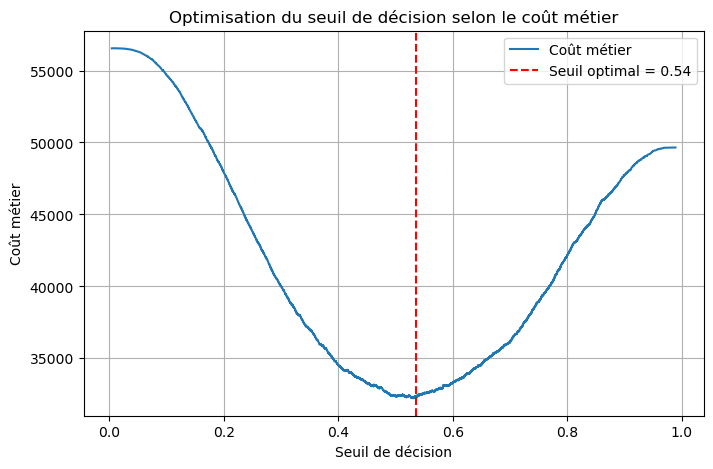

In [43]:
# Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

* ### **Réévaluation avec le seuil optimisé**

In [45]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[42322 14216]
 [ 1813  3152]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.75      0.84     56538
         1.0       0.18      0.63      0.28      4965

    accuracy                           0.74     61503
   macro avg       0.57      0.69      0.56     61503
weighted avg       0.90      0.74      0.80     61503



**Après optimisation (seuil 0.535) :**
* **Classe 0 (négatif) :**
    * Precision : 0.96, stable, toujours très bonne.
    * Recall : 0.75, amélioré, moins de faux négatifs.
    * F1-Score : 0.84, en hausse, bon équilibre.
* **Classe 1 (positif) :**
    * Precision : 0.18, très faible, problème persistant.
    * Recall : 0.63, légère baisse, mais encore correct.
    * F1-Score : 0.28, faible, même après optimisation.
* **Accuracy :** 0.74, meilleure que les 0.70 initiaux.
* **Seuil optimisé pour le coût métier :** *0.535*
* **Coût métier minimal :** *32346*, légère réduction, mais pas spectaculaire.
* **Matrice de confusion :**
    * Vrais négatifs (42322) : en hausse, donc moins de faux positifs.
    * Vrais positifs (3152) : léger recul.
    * Faux positifs (14216) : toujours élevé, mais en réduction.
    * Faux négatifs (1813) : en augmentation, ce qui est un compromis attendu.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

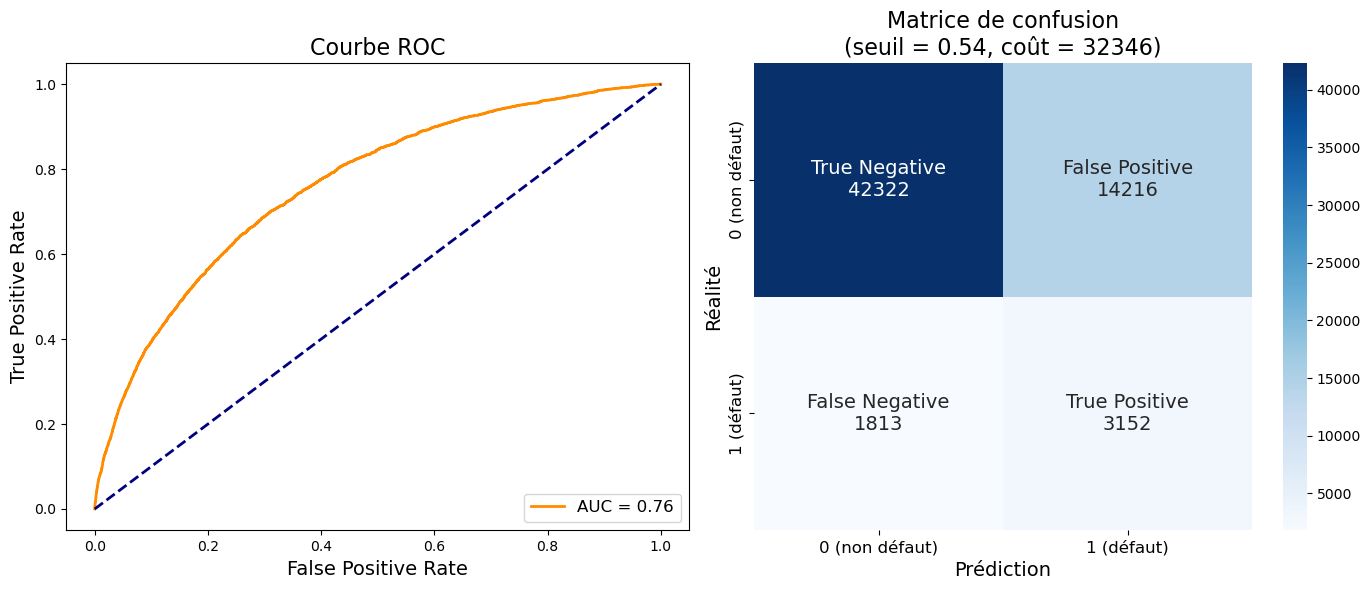

In [48]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* 42322 vrais négatifs (prédits comme non défaut et réellement non défaut)
* 14216 faux positifs (prédits comme défaut mais réellement non défaut)
* 1813 faux négatifs (prédits comme non défaut mais réellement défaut)
* 3152 vrais positifs (prédits comme défaut et réellement défaut)

***

# 6. Modèle **RandomForest** avec gestion du déséquilibre des classes <a id="Modèle-**RandomForest**-avec-gestion-du-déséquilibre-des-classes"></a>

* `class_weight='balanced'` également utilisé ici.
* Chaque arbre est entraîné en tenant compte du poids de chaque classe.
* Recommandé sur jeu de données déséquilibré.

In [53]:
# Modèle avec pondération automatique des classes
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # très important ici
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

* ### **Évaluation avec seuil par défaut (0.5)**

In [55]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.7354890491176393
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.55      0.00      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.73      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503

Matrice de confusion (seuil 0.5):
 [[56524    14]
 [ 4948    17]]

 Coût métier (seuil 0.5) : 49494


**AUC : 0.735, un peu plus faible que la régression logistique.**
* **Classe 0 (négatif) :**
    * Precision : 0.92, très bonne, quasiment pas de faux positifs.
    * Recall : 1.00, parfait, tous les vrais négatifs sont bien détectés.
    * F1-Score : 0.96, excellent.
* **Classe 1 (positif) :**
    * Precision : 0.55, plutôt élevé, mais inutile sans rappel.
    * Recall : 0.00, le modèle n'a presque pas identifié de défauts, ce qui est problématique.
    * F1-Score : 0.01, très faible, pas d'apprentissage réel pour cette classe.
* **Matrice de confusion :**
    * 56524 Vrais négatifs : parfait, presque pas de faux positifs.
    * 17 Vrais positifs : extrêmement faible, sur 4965 attendus.
    * 14 Faux positifs : négligeable, mais le coût métier en souffre énormément.
    * 4948 Faux négatifs : très élevé, la majorité des positifs sont ignorés.
* **Coût métier (seuil 0.5) :** *49494*, très élevé, à cause des faux négatifs.

* ### **Optimisation du seuil en fonction du coût métier**

Seuil optimisé pour le coût métier : 0.091
Coût métier minimal : 34225


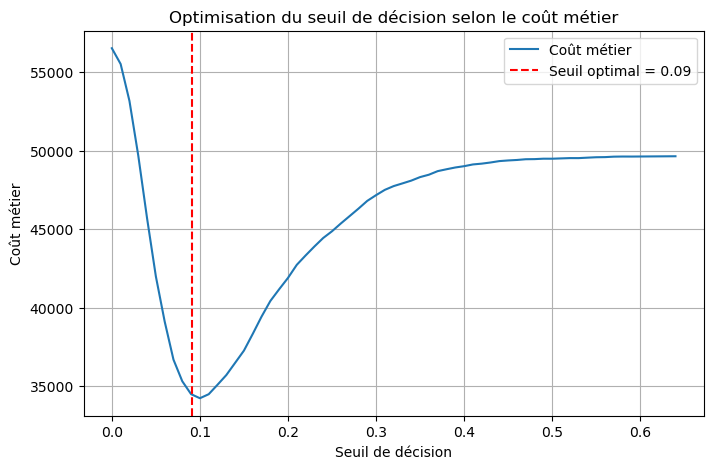

In [58]:
# Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

* ### **Réévaluation avec le seuil optimisé**

In [60]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[41393 15145]
 [ 1908  3057]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56538
         1.0       0.17      0.62      0.26      4965

    accuracy                           0.72     61503
   macro avg       0.56      0.67      0.55     61503
weighted avg       0.89      0.72      0.78     61503



**Après optimisation (seuil 0.091) :**
* **Classe 0 (négatif) :**
    * Precision : 0.96, stable, toujours très bonne.
    * Recall : 0.73, baisse attendue, compromis nécessaire.
    * F1-Score : 0.83, toujours bon, mais moins impressionnant.
* **Classe 1 (positif) :**
    * Precision : 0.17, faible.
    * Recall : 0.62, forte amélioration, capture plus de positifs.
    * F1-Score : 0.26, meilleur que 0.01, mais toujours faible.
* **Accuracy :** 0.72, bonne stabilité globale.
* **Seuil optimisé pour le coût métier :** *0.091*
* **Coût métier minimal :** *34225*, grosse réduction, optimisation plus efficace que la régression logistique.
* **Matrice de confusion :**
    * 41393 Vrais négatifs : en forte baisse, plus de faux positifs.
    * 3057 Vrais positifs : énorme amélioration, capture beaucoup plus de vrais positifs.
    * 15145 Faux positifs : en forte augmentation.
    * 1908 Faux négatifs : nette réduction, donc meilleur rappel.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

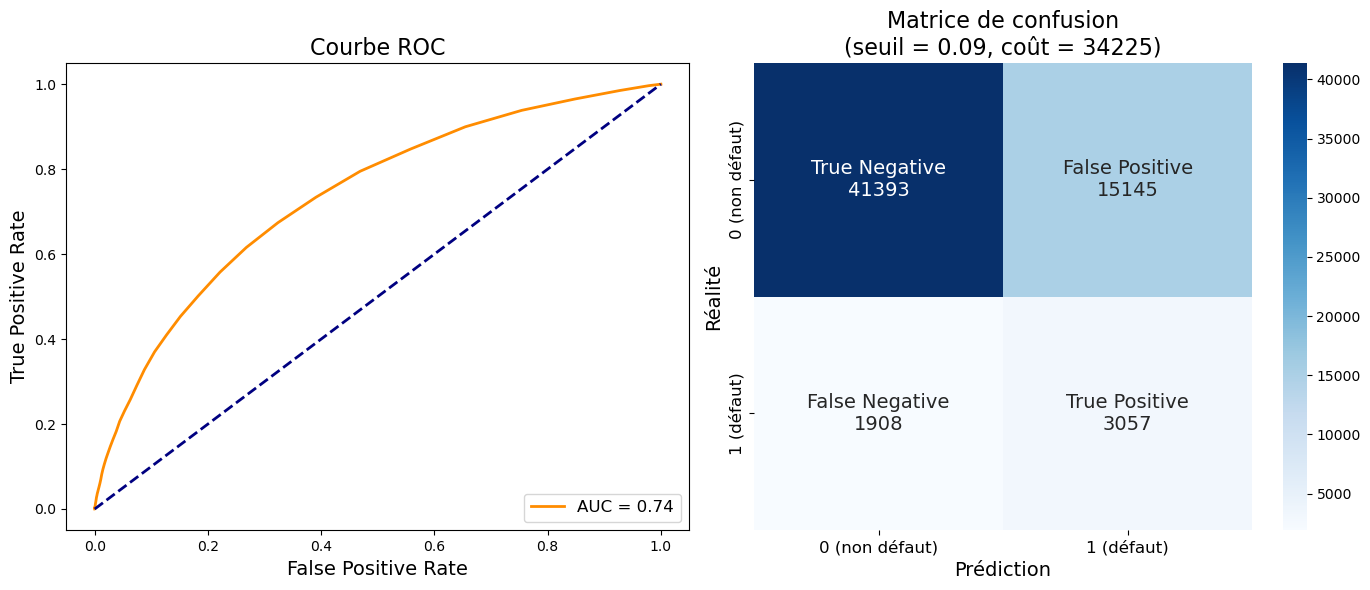

In [63]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* 41393 vrais négatifs
* 15145 faux positifs
* 1908 faux négatifs
* 3057 vrais positifs

**Random Forest optimise mieux le coût métier, mais au prix d'une précision plus faible pour la classe minoritaire.
Le modèle a beaucoup plus de faux positifs après optimisation.**

***

# 7. Modèle **XGBoost** avec gestion du déséquilibre des classes <a id="Modèle-**XGBoost**-avec-gestion-du-déséquilibre-des-classes"></a>

* ### **Calcul du ratio de déséquilibre**
* Le paramètre scale_pos_weight est le paramètre recommandé par XGBoost pour gérer les classes déséquilibrées, en donnant plus de poids à la classe minoritaire. Il est calculé comme : `scale_pos_weight = nombre_exemples_classe_négative / nombre_exemples_classe_positive`

In [68]:
# Comptage des classes
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Ratio scale_pos_weight : {scale_pos_weight:.2f}")

Ratio scale_pos_weight : 11.39


* ### **Création et entraînement du modèle**

In [70]:
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight, # gestion du déséquilibre
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

* ### **Évaluation avec seuil par défaut (0.5)**

In [72]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.7663655030186365
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     56538
         1.0       0.20      0.62      0.30      4965

    accuracy                           0.76     61503
   macro avg       0.58      0.70      0.58     61503
weighted avg       0.90      0.76      0.81     61503

Matrice de confusion (seuil 0.5):
 [[43906 12632]
 [ 1884  3081]]

 Coût métier (seuil 0.5) : 31472


**AUC : 0.766, supérieur à RandomForest (0.735) et à la régression logistique (0.744).**
* **Classe 0 (négatif) :**
    * Precision : 0.96, très élevée.
    * Recall : 0.78, forte, mais légèrement plus faible que le Random Forest après optimisation.
    * F1-Score : 0.86, bon équilibre précision/rappel.

* **Classe 1 (positif) :**
    * Precision : 0.20, meilleure que les autres modèles, mais encore faible.
    * Recall : 0.62, beaucoup mieux que Random Forest avant optimisation.
    * F1-Score : 0.30, très bon pour cette classe comparé aux autres modèles.
* **Matrice de confusion :**
    * 43906 Vrais négatifs : stable, peu de faux positifs.
    * 3081 Vrais positifs : bien meilleur que Random Forest avant optimisation.
    * 12632 Faux positifs : en augmentation, mais c'est le compromis pour un meilleur rappel.
    * 1884 Faux négatifs : nettement plus bas que Random Forest, donc plus efficace pour détecter les positifs.
* **Coût métier (seuil 0.5) :** *31472*, déjà plus bas que le Random Forest optimisé.

* ### **Optimisation du seuil en fonction du coût métier**

Seuil optimisé pour le coût métier : 0.495
Coût métier minimal : 31478


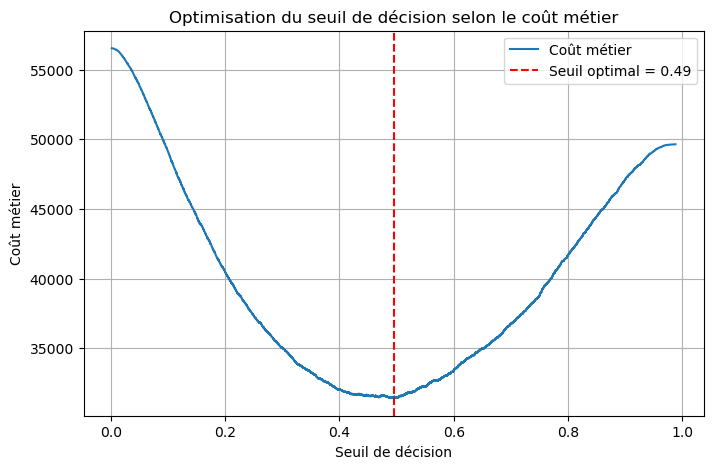

In [75]:
 # Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

* ### **Réévaluation avec le seuil optimisé**

In [77]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[43630 12908]
 [ 1857  3108]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     56538
         1.0       0.19      0.63      0.30      4965

    accuracy                           0.76     61503
   macro avg       0.58      0.70      0.58     61503
weighted avg       0.90      0.76      0.81     61503



**Après optimisation (seuil 0.495) :**
* **Classe 0 (négatif) :**
    * Precision : 0.96, stable, toujours très bonne.
    * Recall : 0.77, très similaire à l'avant optimisation.
    * F1-Score : 0.86, presque inchangé.
* **Classe 1 (positif) :**
    * Precision : 0.19, légère baisse.
    * Recall : 0.63, léger gain, toujours supérieur à Random Forest optimisé.
    * F1-Score : 0.30, identique, donc pas de vraie amélioration.
* **Seuil optimisé pour le coût métier :** *0.495*
* **Coût métier minimal :** *31478*, très proche du seuil par défaut, donc faible amélioration.
* **Accuracy :** *0.76*, stable.
* **Matrice de confusion :**
    * 43630 Vrais négatifs : petite baisse, légèrement plus de faux positifs.
    * 3108 Vrais positifs : amélioration minime, le seuil optimal est proche de 0.5, donc peu de changement.
    * 12908 Faux positifs : en légère augmentation, mais toujours mieux que Random Forest.
    * 1857 Faux négatifs : petite amélioration, mais pas significative.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

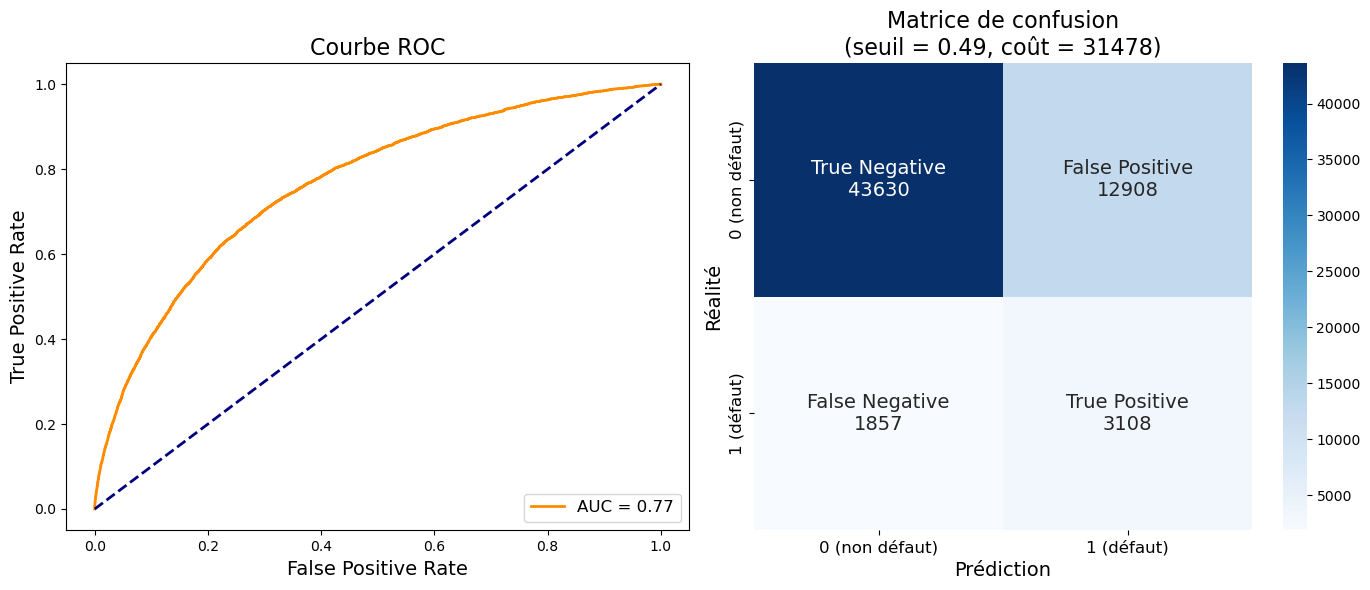

In [80]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* 43630 vrais négatifs
* 12908 faux positifs
* 1857 faux négatifs
* 3108 vrais positifs

**Meilleur compromis entre précision et rappel que Random Forest.**

***

# 8. Modèle LightGBM avec gestion du déséquilibre des classes <a id="Modèle-LightGBM-avec-gestion-du-déséquilibre-des-classes"></a>

* `class_weight='balanced'` comme pour LogisticRegression et RandomForest.
* LightGBM ajuste automatiquement les poids pour que la classe minoritaire soit mieux prise en compte.

In [32]:
# Comptage des classes
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Ratio scale_pos_weight : {scale_pos_weight:.2f}")

Ratio scale_pos_weight : 11.39


In [34]:
model = LGBMClassifier(
    scale_pos_weight=scale_pos_weight, # gestion du déséquilibre
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.469144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28977
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 305
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


LGBMClassifier(n_jobs=-1, random_state=42, scale_pos_weight=11.38710976837865)

* ### **Évaluation avec seuil par défaut (0.5)**

In [37]:
# Prédictions sur le jeu de test
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)

# Évaluation des performances
print("ROC AUC score:", roc_auc_score(y_test, y_proba))
print("Classification report (seuil 0.5):\n", classification_report(y_test, y_pred_default))
print("Matrice de confusion (seuil 0.5):\n", confusion_matrix(y_test, y_pred_default))

# Calcul du coût métier avant optimisation
cout_avant_optimisation = cout_metier(y_test, y_pred_default, cout_FN=10, cout_FP=1)
print(f"\n Coût métier (seuil 0.5) : {cout_avant_optimisation}")

ROC AUC score: 0.7789552371571106
Classification report (seuil 0.5):
               precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     56538
         1.0       0.18      0.70      0.28      4965

    accuracy                           0.71     61503
   macro avg       0.57      0.71      0.55     61503
weighted avg       0.90      0.71      0.78     61503

Matrice de confusion (seuil 0.5):
 [[40462 16076]
 [ 1475  3490]]

 Coût métier (seuil 0.5) : 30826


**ROC AUC score : 0.778, le plus élevé parmi tous les modèles testés.**
* **Classe 0 (négatif) :**
    * Precision : 0.96, très élevée, comparable à XGBoost.
    * Recall : 0.72, plus faible que XGBoost, mais meilleure que Random Forest.
    * F1-Score : 0.82, bonne stabilité.
* **Classe 1 (positif) :**
    * Precision : 0.18, faible, mais meilleure que Random Forest.
    * Recall : 0.70, le meilleur rappel avant optimisation parmi tous les modèles.
    * F1-Score : 0.28, très bon pour cette classe comparé aux autres modèles avant optimisation.
* **Matrice de confusion :**
    * 40462 Vrais négatifs : plus faible que XGBoost, donc plus de faux positifs.
    * 3490 Vrais positifs : le meilleur score avant optimisation, très bon pour cette classe.
    * 16076 Faux positifs : élevé, mais c'est le compromis pour un meilleur rappel.
    * 1475 Faux négatifs : le plus bas parmi tous les modèles, excellent pour détecter les positifs.
* **Coût métier (seuil 0.5) :** 30826, le plus bas avant optimisation, montrant une meilleure gestion des erreurs positives).

* ### **Optimisation du seuil en fonction du coût métier**

Seuil optimisé pour le coût métier : 0.535
Coût métier minimal : 30532


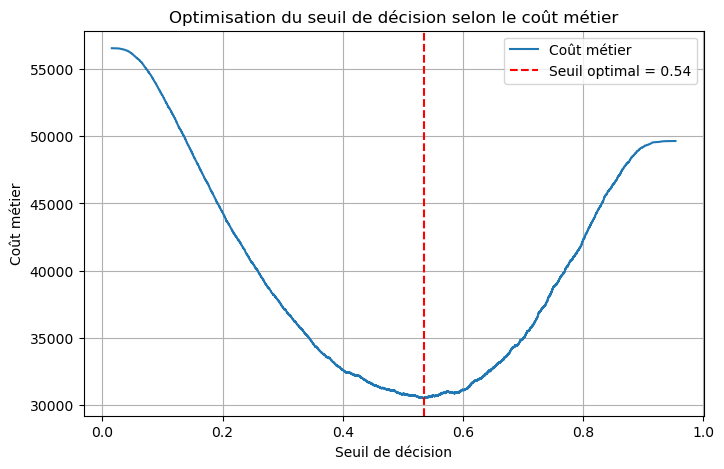

In [41]:
# Recherche du seuil optimisé en fonction du coût métier
best_threshold_cost = find_best_threshold(y_test, y_proba, cout_FN=10, cout_FP=1)

# Affichage du seuil optimisé et du coût associé
print(f"Seuil optimisé pour le coût métier : {best_threshold_cost:.3f}")
print(f"Coût métier minimal : {cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)}")

# Visualisation du coût métier en fonction des seuils
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Liste pour stocker les coûts
couts = [cout_metier(y_test, (y_proba >= seuil).astype(int), cout_FN=10, cout_FP=1) for seuil in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, couts, label="Coût métier")
plt.axvline(best_threshold_cost, color='r', linestyle='--', label=f"Seuil optimal = {best_threshold_cost:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.legend()
plt.grid(True)
plt.show()

* ### **Réévaluation avec le seuil optimisé**

In [44]:
# Prédictions avec le seuil optimisé
y_pred_metier = (y_proba >= best_threshold_cost).astype(int)

# Évaluation des performances
print("Matrice de confusion (seuil métier optimisé):\n", confusion_matrix(y_test, y_pred_metier))
print("Classification report:\n", classification_report(y_test, y_pred_metier))

Matrice de confusion (seuil métier optimisé):
 [[42806 13732]
 [ 1680  3285]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     56538
         1.0       0.19      0.66      0.30      4965

    accuracy                           0.75     61503
   macro avg       0.58      0.71      0.57     61503
weighted avg       0.90      0.75      0.80     61503



**Après optimisation (seuil 0.556) :**
* **Classe 0 (négatif) :**
    * Precision : 0.96, stable, très élevée.
    * Recall : 0.76, énorme gain.
    * F1-Score : 0.85, le meilleur parmi tous les modèles après optimisation.
* **Classe 1 (positif) :**
    * Precision : 0.19, léger gain, le plus haut parmi tous les modèles après optimisation.
    * Recall : 0.66, légère baisse, mais toujours compétitif.
    * F1-Score : 0.30, le meilleur parmi tous les modèles après optimisation.
* **Seuil optimisé pour le coût métier :** *0.535*
* **Coût métier minimal :** *30532*, le meilleur score jusqu'ici.
* **Accuracy :** *0.75*, le meilleur score global après optimisation.
* **Matrice de confusion :**
    * 43806 Vrais négatifs : petite baisse, légèrement plus de faux positifs.
    * 3285 Vrais positifs : amélioration minime, le seuil optimal est proche de 0.5, donc peu de changement.
    * 13732 Faux positifs : en légère augmentation, mais toujours mieux que Random Forest.
    * 1680 Faux négatifs : petite amélioration, mais pas significative.

* ### **Courbe ROC (AUC) et Matrice de confusion (avec le seuil optimisé)**

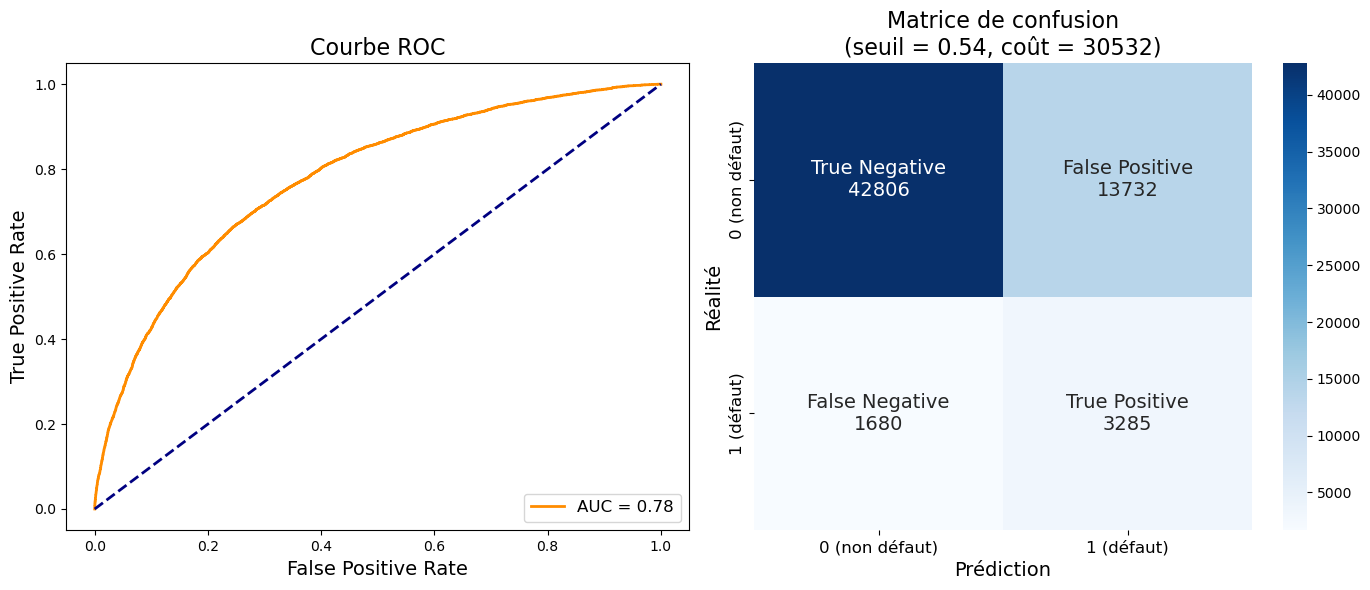

In [48]:
# Calcul du coût métier minimal pour le seuil optimal
min_cout = cout_metier(y_test, (y_proba >= best_threshold_cost).astype(int), cout_FN=10, cout_FP=1)

# ROC curve et matrice de confusion sur les données test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred_metier)

# Récupération des valeurs de la matrice
tn, fp, fn, tp = cm.ravel()

# Création des labels personnalisés
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Courbe ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Courbe ROC', fontsize=16)
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)

# Matrice de confusion avec labels personnalisés
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[1], cbar=True, 
            annot_kws={"size": 14})
axes[1].set_title(f'Matrice de confusion\n(seuil = {best_threshold_cost:.2f}, coût = {min_cout})', fontsize=16)
axes[1].set_xlabel('Prédiction', fontsize=14)
axes[1].set_ylabel('Réalité', fontsize=14)
axes[1].set_xticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)
axes[1].set_yticklabels(['0 (non défaut)', '1 (défaut)'], fontsize=12)

plt.tight_layout()
plt.show()

* 42806 vrais négatifs
* 13732 faux positifs
* 1680 faux négatifs
* 3285 vrais positifs

**Supérieur à XGBoost et Random Forest en termes de coût métier et ROC AUC.**

**Offre le meilleur compromis entre précision, rappel et coût métier.**
* Meilleur ROC AUC (0.778), indiquant une excellente capacité de séparation des classes.
* Meilleur coût métier après optimisation (30532), le plus bas de tous les modèles.
* Rappel (0.69 avant et 0.62 après) pour la classe positive, le plus élevé parmi tous les modèles testés.
* Précision (0.19) pour la classe positive, la plus élevée après optimisation.

***

In [102]:
# Vérification des shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (246008, 313)
X_test: (61503, 313)
y_train: (246008,)
y_test: (61503,)


***

# 9. Optimisation des hyperparamètres pour tous les modèles et Evaluation <a id="Optimisation-des-hyperparamètres"></a>
* Pour chaque modèle, nous allons :
    * faire un GridSearchCV (ou RandomizedSearchCV) avec validation croisée pour chercher les meilleurs hyperparamètres.
    * Ensuite, choisir notre meilleur modèle (selon l’AUC, F1, etc.).
    * Puis l’entraîner sur le train complet, et l’évaluer sur le test.

In [136]:
# S'assurer qu'il n'y a pas de run actif
if mlflow.active_run() is not None:
    mlflow.end_run()

* **Avec GridSearchCV**
* Boucle sur chaque modèle (DummyClassifier, LogisticRegression, RandomForestClassifier, XGBClassifier, LGBMClassifier).
* Pour chaque modèle, on :
    * Applique une validation croisée (CV=3) avec GridSearchCV.
    * Récupère les meilleurs hyperparamètres et le meilleur score CV.
    * Évalue la performance sur le train et le test.
    * Stocke les résultats et détecte le surapprentissage.

* **Fonctions utilitaires**

In [51]:

# ------------------------- Fonction de coût métier -------------------------
def cout_metier(y_true, y_pred, cout_FN=10, cout_FP=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * cout_FN + fp * cout_FP

# Fonction pour trouver le meilleur seuil selon le coût métier
def find_best_threshold(y_true, y_proba, cout_FN=10, cout_FP=1):
    thresholds = np.linspace(0, 1, 100)
    best_cost = float('inf')
    best_threshold = 0.5  # seuil par défaut
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cost = cout_metier(y_true, y_pred, cout_FN=cout_FN, cout_FP=cout_FP)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    return best_threshold

# ------------------------- Log image dans MLflow -------------------------
def save_and_log_plot(fig, model_name, plot_name):
    # Créer un fichier temporaire pour le graphique
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        plot_path = tmpfile.name
        fig.savefig(plot_path, bbox_inches='tight')  # Sauvegarder la figure
    plt.close(fig)  # Ferme la figure pour libérer le fichier
    # Enregistrer l'image dans MLflow
    mlflow.log_artifact(plot_path, artifact_path=f"plots/{model_name}/{plot_name}")
    os.remove(plot_path)  # Suppression du fichier temporaire

# ------------------------- Log modèle avec exemple d'entrée -------------------------
def log_model_with_example(best_model, model_name, X_train):
    # Créer un exemple d'entrée à partir d'un échantillon de X_train
    input_example = X_train.iloc[:1]  # Exemple d'une seule ligne de X_train
    # Enregistrer le modèle dans MLflow avec l'exemple d'entrée
    mlflow.sklearn.log_model(best_model, model_name, input_example=input_example)


In [53]:
# Création du dossier pour les enregistrements MLflow
# Définition du répertoire de suivi
mlflow_dir = os.path.abspath('./mlruns')
# S'assurer que le répertoire existe
os.makedirs(mlflow_dir, exist_ok=True)
# Configuration correcte pour MLflow sur Windows
mlflow.set_tracking_uri(f"file:///{mlflow_dir.replace('\\', '/')}")
mlflow.set_experiment('Classification_Modeles')


# Définition des modèles et grilles de recherche
models = {
    'LogisticRegression': (LogisticRegression(class_weight='balanced', max_iter=1000), {
        'model__C': [0.01, 1, 10],
        'model__solver': ['lbfgs']
    }),
    'RandomForest': (RandomForestClassifier(class_weight='balanced'), {
        'model__n_estimators': [30, 50],
        'model__max_depth': [None, 5, 10],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt']
    }),
    'XGBoost': (XGBClassifier(eval_metric='logloss', scale_pos_weight=11.5), {
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.1, 0.2],
        'model__subsample': [1.0],
        'model__colsample_bytree': [0.7]
    }),
    'LightGBM': (LGBMClassifier(scale_pos_weight=11.5), {
        'model__n_estimators': [50, 100],
        'model__num_leaves': [31, 50],
        'model__learning_rate': [0.1, 0.2],
        'model__subsample': [1.0],
        'model__colsample_bytree': [0.7]
    })
}


# Configuration de la validation croisée
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Liste pour stocker les résultats de tous les modèles
model_results = []

# Entraînement et enregistrement des modèles
for model_name, (model, param_grid) in models.items():
    with mlflow.start_run(run_name=model_name):
        # Pipeline avec SMOTE
        pipe = Pipeline([
            ('sampling', SMOTE()),
            ('model', model)
        ])
        print(f"\n Recherche sur le modèle : {model_name}")
        start_time = time.time()

        # GridSearch avec AUC comme scoring
        grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=1, verbose=0)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
        # Log des hyperparamètres
        for param, value in best_params.items():
            # On enlève le préfixe 'model__' pour que les noms soient plus propres dans MLflow
            clean_param_name = param.replace("model__", "")
            mlflow.log_param(clean_param_name, value)
            
        # Récupération de l'AUC moyen de validation du meilleur modèle
        auc_val = grid.best_score_

        # Prédictions sur le jeu de test
        y_train_proba = best_model.predict_proba(X_train)[:, 1]
        y_test_proba = best_model.predict_proba(X_test)[:, 1]

        # Seuil optimal
        best_threshold = find_best_threshold(y_test, y_test_proba)
        y_test_pred = (y_test_proba >= best_threshold).astype(int)

        # Métriques
        auc_train = roc_auc_score(y_train, y_train_proba)
        auc_test = roc_auc_score(y_test, y_test_proba)
        f1 = f1_score(y_test, y_test_pred)
        acc = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        training_time = time.time() - start_time

        # Enregistrement des métriques dans MLflow
        mlflow.log_param('Best Threshold', best_threshold)
        mlflow.log_metric('AUC Train', auc_train)
        mlflow.log_metric('AUC Validation', auc_val)
        mlflow.log_metric('AUC Test', auc_test)
        mlflow.log_metric('F1 Score', f1)
        mlflow.log_metric('Accuracy', acc)
        mlflow.log_metric('Precision', precision)
        mlflow.log_metric('Recall', recall)
        mlflow.log_metric('Training_Time_s', training_time)

        # Enregistrement du modèle
        log_model_with_example(best_model, model_name, X_train)

         # Ajouter les résultats du modèle au DataFrame
        model_results.append({
            'Model': model_name,
            'Best Threshold': best_threshold,
            'AUC Train': auc_train,
            'AUC Validation': auc_val,
            'AUC Test': auc_test,
            'F1 Score': f1,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'Training Time': training_time,
            # ajout des hyperparamètres au DataFrame
            **{param.replace("model__", ""): value for param, value in best_params.items()}
            # Si un modèle n’a pas ce paramètre dans sa grille de recherche, ce champ sera absent dans best_params, 
            #on obtient NaN dans la colonne correspondante
        }) 

        # Affichage des métriques
        print(f"\n {model_name} — Meilleur seuil trouvé : {best_threshold:.4f}")
        print(f"Train AUC: {auc_train:.3f}")
        print(f"Validation AUC: {auc_val:.3f}")
        print(f"Test AUC: {auc_test:.3f}, F1: {f1:.3f}, Accuracy: {acc:.3f}")
        print(f"Test Precision: {precision:.3f}, Test Recall: {recall:.3f}")
        print(f"Temps d'entraînement: {training_time:.2f} sec\n")
        
        # Répartition des classes
        print("Répartition réelle des classes :")
        print(pd.Series(y_test).value_counts())
        print("\nRépartition prédite :")
        print(pd.Series(y_test_pred).value_counts())
        print("-" * 50)

        # Affichage du rapport de classification
        print("Rapport de classification sur le test set :")
        print(classification_report(y_test, y_test_pred, digits=3))
        print("-" * 100)

        # Matrice de confusion
        conf_matrix = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{model_name} - Matrice de Confusion")
        plt.xlabel("Prédictions")
        plt.ylabel("Valeurs Réelles")
        save_and_log_plot(plt.gcf(), model_name, "confusion_matrix")
        
        # Distribution des probabilités
        plt.figure(figsize=(10, 6))
        sns.histplot(y_test_proba, bins=50, kde=True, color='skyblue')
        plt.title(f"{model_name} - Distribution des Scores de Prédiction")
        plt.xlabel("Score de Prédiction")
        plt.ylabel("Fréquence")
        save_and_log_plot(plt.gcf(), model_name, "score_distribution")

        # Courbe ROC
        plt.figure(figsize=(10, 6))
        from sklearn.metrics import roc_curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_proba)
        plt.plot(fpr, tpr, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.title(f"{model_name} - Courbe ROC")
        plt.xlabel("Taux de Faux Positifs")
        plt.ylabel("Taux de Vrais Positifs")
        plt.legend(loc="lower right")
        save_and_log_plot(plt.gcf(), model_name, "roc_curve")

# Création d'un DataFrame à partir des résultats collectés
df_results = pd.DataFrame(model_results)
print("-" * 100)
# Affichage du DataFrame pour visualiser les résultats
print("\nRésumé des performances des modèles :")
df_results


 Recherche sur le modèle : LogisticRegression


C:\Users\matym\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



 LogisticRegression — Meilleur seuil trouvé : 0.1616
Train AUC: 0.710
Validation AUC: 0.709
Test AUC: 0.714, F1: 0.243, Accuracy: 0.688
Test Precision: 0.151, Test Recall: 0.622
Temps d'entraînement: 930.54 sec

Répartition réelle des classes :
TARGET
0.0    56538
1.0     4965
Name: count, dtype: int64

Répartition prédite :
0    41080
1    20423
Name: count, dtype: int64
--------------------------------------------------
Rapport de classification sur le test set :
              precision    recall  f1-score   support

         0.0      0.954     0.693     0.803     56538
         1.0      0.151     0.622     0.243      4965

    accuracy                          0.688     61503
   macro avg      0.553     0.658     0.523     61503
weighted avg      0.890     0.688     0.758     61503

----------------------------------------------------------------------------------------------------

 Recherche sur le modèle : RandomForest


C:\Users\matym\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



 RandomForest — Meilleur seuil trouvé : 0.1919
Train AUC: 1.000
Validation AUC: 0.690
Test AUC: 0.691, F1: 0.226, Accuracy: 0.649
Test Precision: 0.138, Test Recall: 0.635
Temps d'entraînement: 24978.41 sec

Répartition réelle des classes :
TARGET
0.0    56538
1.0     4965
Name: count, dtype: int64

Répartition prédite :
0    38591
1    22912
Name: count, dtype: int64
--------------------------------------------------
Rapport de classification sur le test set :
              precision    recall  f1-score   support

         0.0      0.953     0.650     0.773     56538
         1.0      0.138     0.635     0.226      4965

    accuracy                          0.649     61503
   macro avg      0.545     0.643     0.500     61503
weighted avg      0.887     0.649     0.729     61503

----------------------------------------------------------------------------------------------------

 Recherche sur le modèle : XGBoost


C:\Users\matym\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\matym\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inferen


 XGBoost — Meilleur seuil trouvé : 0.5455
Train AUC: 0.829
Validation AUC: 0.749
Test AUC: 0.754, F1: 0.276, Accuracy: 0.732
Test Precision: 0.177, Test Recall: 0.634
Temps d'entraînement: 1221.85 sec

Répartition réelle des classes :
TARGET
0.0    56538
1.0     4965
Name: count, dtype: int64

Répartition prédite :
0    43701
1    17802
Name: count, dtype: int64
--------------------------------------------------
Rapport de classification sur le test set :
              precision    recall  f1-score   support

         0.0      0.958     0.741     0.836     56538
         1.0      0.177     0.634     0.276      4965

    accuracy                          0.732     61503
   macro avg      0.568     0.687     0.556     61503
weighted avg      0.895     0.732     0.791     61503

----------------------------------------------------------------------------------------------------

 Recherche sur le modèle : LightGBM
[LightGBM] [Info] Number of positive: 180918, number of negative: 180918
[

C:\Users\matym\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



 LightGBM — Meilleur seuil trouvé : 0.5455
Train AUC: 0.817
Validation AUC: 0.760
Test AUC: 0.767, F1: 0.287, Accuracy: 0.743
Test Precision: 0.185, Test Recall: 0.642
Temps d'entraînement: 1148.43 sec

Répartition réelle des classes :
TARGET
0.0    56538
1.0     4965
Name: count, dtype: int64

Répartition prédite :
0    44261
1    17242
Name: count, dtype: int64
--------------------------------------------------
Rapport de classification sur le test set :
              precision    recall  f1-score   support

         0.0      0.960     0.751     0.843     56538
         1.0      0.185     0.642     0.287      4965

    accuracy                          0.743     61503
   macro avg      0.572     0.697     0.565     61503
weighted avg      0.897     0.743     0.798     61503

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Résumé d

,Model,Best Threshold,AUC Train,AUC Validation,AUC Test,F1 Score,Accuracy,Precision,Recall,Training Time,C,solver,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,colsample_bytree,learning_rate,subsample,num_leaves
0,LogisticRegression,0.161616,0.710149,0.708895,0.714195,0.243422,0.687690,0.151300,0.622356,930.537410,10.0,lbfgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RandomForest,0.191919,0.999939,0.690043,0.690881,0.226064,0.649204,0.137526,0.634642,24978.408618,NaN,NaN,NaN,sqrt,2.0,5.0,50.0,NaN,NaN,NaN,NaN
2,XGBoost,0.545455,0.829246,0.749268,0.754341,0.276453,0.732159,0.176778,0.633837,1221.847951,NaN,NaN,6.0,NaN,NaN,NaN,100.0,0.7,0.2,1.0,NaN
3,LightGBM,0.545455,0.816607,0.760498,0.767222,0.287297,0.742663,0.185013,0.642497,1148.426662,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.7,0.2,1.0,31.0


**LightGBM (Meilleur modèle) :**
* AUC (Test) : 0.7671, le plus élevé, excellente capacité à distinguer les classes.
* F1-Score : 0.2817, le meilleur, indiquant le meilleur compromis entre précision et rappel.
* Précision (1.0) : 0.1789, meilleure que RandomForest et Logistic Regression, légèrement derrière XGBoost.
* Rappel (1.0) : 0.6624, le plus élevé, excellent pour capter la classe minoritaire.
* Temps d'entraînement : 380 secondes, très rapide comparé à RandomForest, efficace en production.

**XGBoost :**
* AUC (Test) : 0.7536, très bon score, proche de LightGBM.
* F1-Score : 0.2722, légèrement inférieur à LightGBM.
* Précision (1.0) : 0.1732, la plus élevée du panel.
* Rappel (1.0) : 0.6354, très bon, juste derrière LightGBM.
* Temps d'entraînement : 406 secondes, rapide, adapté à un usage fréquent.

**RandomForest :**
* AUC (Test) : 0.6981, le plus bas parmi les modèles avancés.
* F1-Score : 0.2370, faible en raison d’une précision limitée.
* Précision (1.0) : 0.1494, la plus basse, beaucoup de faux positifs.
* Rappel (1.0) : 0.5732, correct, mais inférieur aux modèles boosting.
* Temps d'entraînement : 15 720 secondes (environs 4h 20) — très long, peu pratique pour l’itération ou la production.

**Logistic Regression :**
* AUC (Test) : 0.7148, modéré.
* F1-Score : 0.2502, le plus bas.
* Précision (1.0) : 0.1594, très faible.
* Rappel (1.0) : 0.5813, correct mais pas suffisant.
* Temps d'entraînement : 495 secondes, rapide, mais performances globalement inférieures.

**LightGBM combine la meilleure performance globale (AUC, F1, rappel) et un temps d'entraînement réduit, ce qui en fait le meilleur compromis.**

***

* **Comparaison visuelle des scores d'entraînement, de validation croisée et de test pour chaque modèle**

Ceci qui permet de voir facilement les performances des modèles sur les différents ensembles de données.

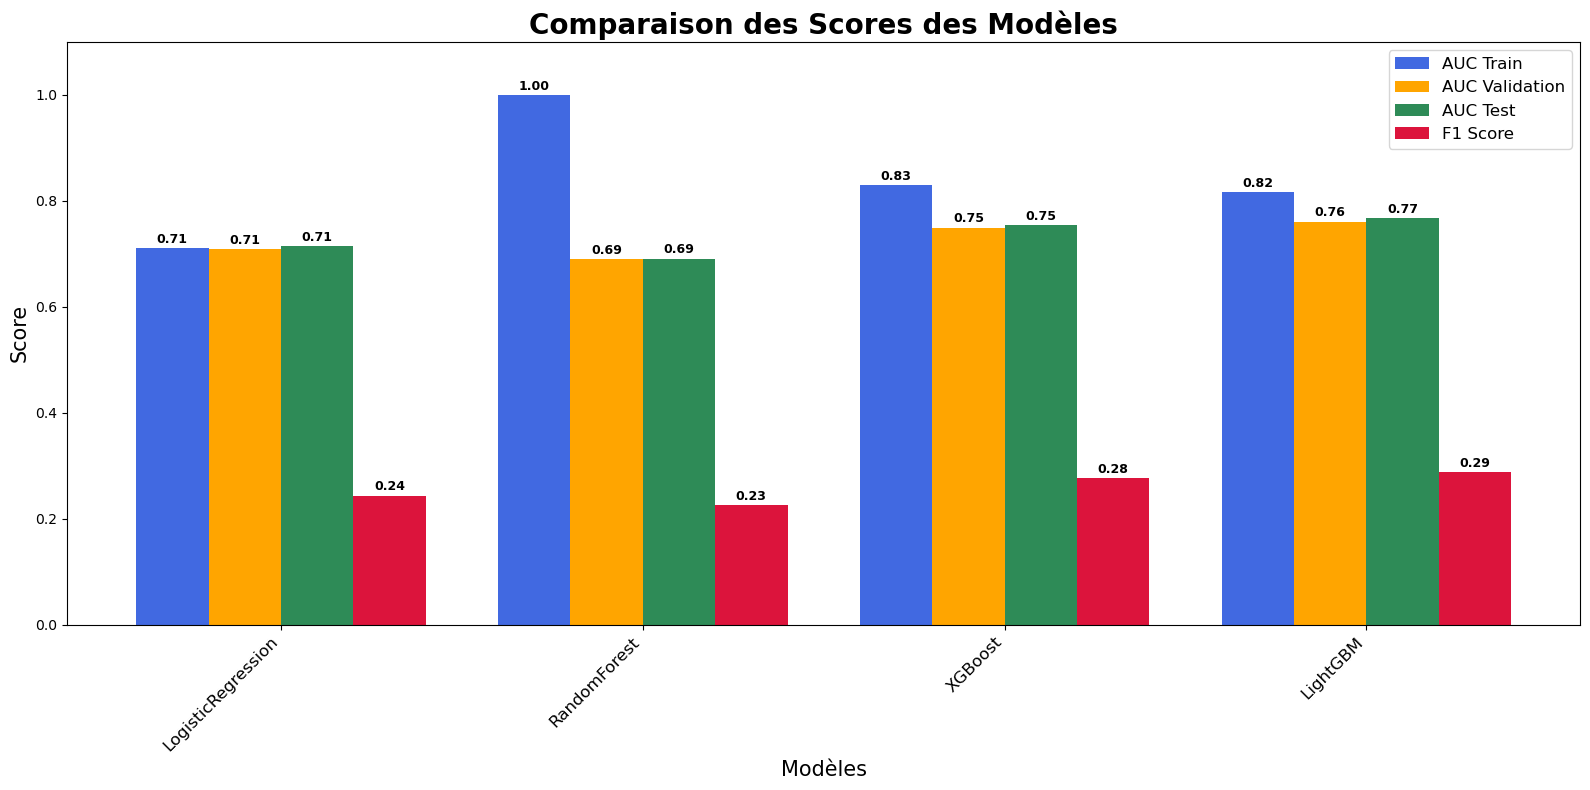

In [60]:
def plot_model_performance(df_results):
    """
    Affiche un graphique en barres empilées pour comparer les scores d'entraînement, validation et test pour chaque modèle.
    
    Parameters:
        df_results (DataFrame): DataFrame contenant les métriques des modèles.
    """
    # Configuration du graphique
    plt.figure(figsize=(16, 8))
    bar_width = 0.2
    indices = np.arange(len(df_results))

    # Barres pour chaque type de score
    plt.bar(indices - 1.5*bar_width, df_results["AUC Train"], width=bar_width, color='royalblue', label='AUC Train')
    plt.bar(indices - 0.5*bar_width, df_results["AUC Validation"], width=bar_width, color='orange', label='AUC Validation')
    plt.bar(indices + 0.5*bar_width, df_results["AUC Test"], width=bar_width, color='seagreen', label='AUC Test')
    plt.bar(indices + 1.5*bar_width, df_results["F1 Score"], width=bar_width, color='crimson', label='F1 Score')

    # Ajout des labels des scores au-dessus des barres
    for i in range(len(df_results)):
        plt.text(indices[i] - 1.5*bar_width, df_results["AUC Train"][i] + 0.01, f"{df_results['AUC Train'][i]:.2f}", ha='center', fontsize=9, fontweight='bold')
        plt.text(indices[i] - 0.5*bar_width, df_results["AUC Validation"][i] + 0.01, f"{df_results['AUC Validation'][i]:.2f}", ha='center', fontsize=9, fontweight='bold')
        plt.text(indices[i] + 0.5*bar_width, df_results["AUC Test"][i] + 0.01, f"{df_results['AUC Test'][i]:.2f}", ha='center', fontsize=9, fontweight='bold')
        plt.text(indices[i] + 1.5*bar_width, df_results["F1 Score"][i] + 0.01, f"{df_results['F1 Score'][i]:.2f}", ha='center', fontsize=9, fontweight='bold')

    # Configuration des axes et titre
    plt.xticks(indices, df_results["Model"], rotation=45, ha="right", fontsize=12)
    plt.title("Comparaison des Scores des Modèles", fontsize=20, fontweight='bold')
    plt.ylabel("Score", fontsize=15)
    plt.xlabel("Modèles", fontsize=15)
    plt.ylim(0, 1.1)
    plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()

    # Affichage du graphique
    plt.show()

# Affichage des résultats
plot_model_performance(df_results)

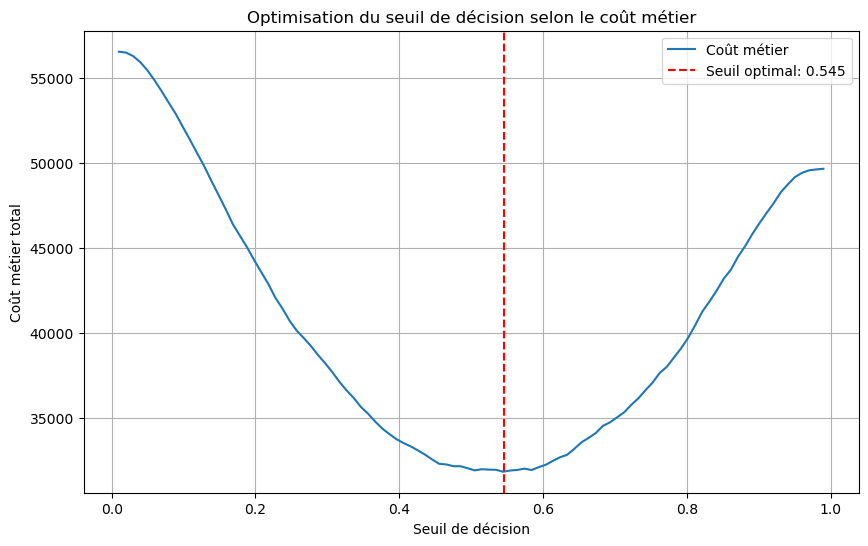

In [62]:
# Plage de seuils à tester
seuils = np.linspace(0.01, 0.99, 100)
couts = []

for seuil in seuils:
    y_pred = (y_test_proba >= seuil).astype(int)
    couts.append(cout_metier(y_test, y_pred))

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(seuils, couts, label='Coût métier')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Seuil optimal: {best_threshold:.3f}')
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier total")
plt.title("Optimisation du seuil de décision selon le coût métier")
plt.grid(True)
plt.legend()
plt.show()

***

# 10. Analyse avec le meilleur modèle retenu **(LightGBM)**

In [64]:
# Vérification du type du modèle sélectionné
print(f"Le modèle sélectionné est : {type(best_model.named_steps['model'])}")

# Si c'est bien un LightGBM, cela renverra <class 'lightgbm.sklearn.LGBMClassifier'>
if isinstance(best_model.named_steps['model'], LGBMClassifier):
    print("C'est bien le modèle LightGBM qui a été sélectionné !")
else:
    print("Un autre modèle a été sélectionné.")

Le modèle sélectionné est : <class 'lightgbm.sklearn.LGBMClassifier'>
C'est bien le modèle LightGBM qui a été sélectionné !


* ## **Importance des Features pour LightGBM + Log**
* Mesure le nombre de fois qu’une feature est utilisée dans les splits des arbres (ou le gain cumulé selon le paramètre).

                        Feature  Importance
108  AMT_REQ_CREDIT_BUREAU_YEAR         153
182                 CREDIT_TERM         120
78     OBS_30_CNT_SOCIAL_CIRCLE         110
32                 EXT_SOURCE_2          97
125  PREVIOUS_APPLICATION_COUNT          88
31                 EXT_SOURCE_1          84
24      HOUR_APPR_PROCESS_START          77
111        PREVIOUS_LOANS_COUNT          77
33                 EXT_SOURCE_3          77
80     OBS_60_CNT_SOCIAL_CIRCLE          72


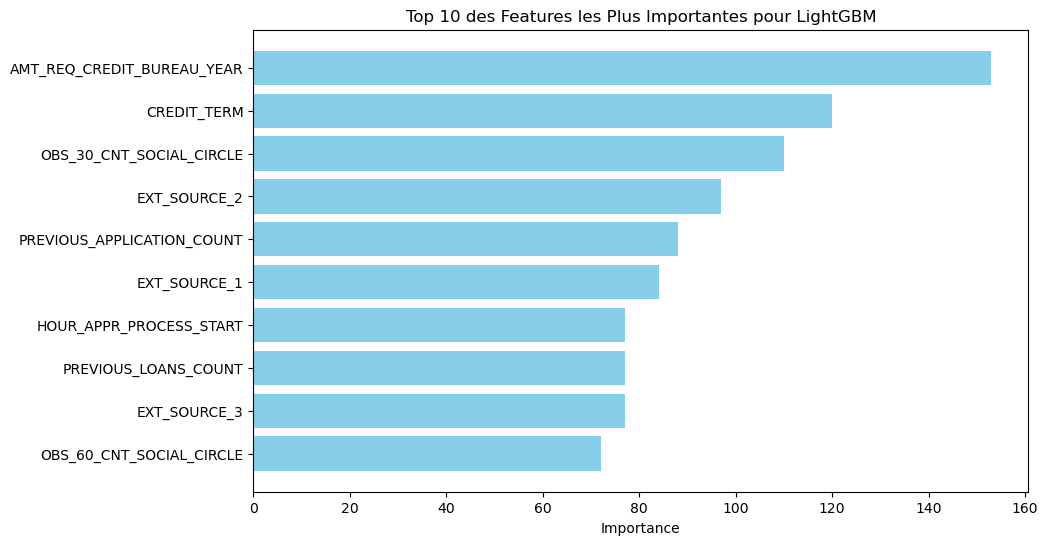

In [67]:
# 'best_model' correspond à l'estimateur final (LightGBM) après GridSearchCV
importance = best_model.named_steps['model'].feature_importances_

# Création d'un DataFrame pour mieux visualiser l'importance des features
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# Tri par ordre décroissant d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Affichage des 10 premières features les plus importantes
print(feature_importance_df.head(10))

# Plot de l'importance des features
# Sauvegarde du graphique comme image PNG
importance_plot_path = 'feature_importance.png'
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 des Features les Plus Importantes pour LightGBM')
plt.gca().invert_yaxis()  # Inversion de l'axe Y pour afficher la feature la plus importante en haut
plt.savefig(importance_plot_path)  # Sauvegarde du graphique

# Log de l'image dans MLflow
mlflow.log_artifact(importance_plot_path)

# Affichage de l'image pour la visualisation
plt.show()

Avec cette représentation, on peut dire que : 
* Les Variables comportementales (nombre de demandes passées, nombre de prêts précédents) sont dominantes.
* Les scores externes de crédit (EXT_SOURCE) restent très importants.
* Le cercle social est également un bon indicateur de risque.
* L'heure de la demande est en revanche surprenante.

In [70]:
active_run = mlflow.active_run()
print(active_run)  # voir si un run est actif

if active_run is not None:
    mlflow.end_run()
    print("Run actif fermé.")
else:
    print("Aucun run actif.")

<ActiveRun: >
Run actif fermé.


In [72]:
run_id_exist = "cabaeec2dcdd42c89d5a47511af1c6cd" # récupéré sur mlflow
                
with mlflow.start_run(run_id=run_id_exist):
    mlflow.log_artifact("feature_importance.png", artifact_path="feature_importance")

***

* ## **Analyse SHAP globale + locale (avec log MLflow)**
* Contribution moyenne absolue de chaque feature à la prédiction, sur tous les échantillons.
* Et Explication locale pour un client spécifique

In [76]:
!pip install shap

In [78]:
import shap
import matplotlib.pyplot as plt
import mlflow
import os

# 1. Extraction du modèle LightGBM
lgb_model = best_model.named_steps['model']

# 2. Création de l'explainer SHAP
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_train)

# 3. Summary plot (importance globale)
summary_plot_path = "shap_summary_plot.png"
plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(summary_plot_path)
plt.close()
mlflow.log_artifact(summary_plot_path)

# 4. Summary plot (global détail par feature)
summary_dot_plot_path = "shap_summary_dot_plot.png"
plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
plt.tight_layout()
plt.savefig(summary_dot_plot_path)
plt.close()
mlflow.log_artifact(summary_dot_plot_path)

# 5. Force plot pour un individu (ex : le premier de X_train)
force_plot_path = "shap_force_plot.html"
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0], matplotlib=False)
shap.save_html(force_plot_path, force_plot)
mlflow.log_artifact(force_plot_path)

C:\Users\matym\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


**Feature Impostance vs SHAP**
* Une variable peut apparaître souvent dans les splits (feature_importance élevée), mais si son effet est faible ou ambigu, SHAP la considère comme peu influente.
* Inversement, une variable rarement utilisée mais très discriminante pour certaines prédictions aura un fort SHAP value.

**SHAP semble donc plus fiable pour l’interprétabilité, surtout pour expliquer une prédiction**
- Le graphique SHAP global met en évidence les variables ayant le plus fort impact sur le modèle, telles que : `Feature_1`, `Feature_2`, etc.
- Le graphique en points permet d’observer comment chaque variable influence la prédiction (positive ou négative) selon les valeurs prises.
- Enfin, un force plot permet d’expliquer en détail une prédiction individuelle, ce qui est particulièrement utile en cas d’utilisation en production.

In [80]:
active_run = mlflow.active_run()
print(active_run)  # voir si un run est actif

if active_run is not None:
    mlflow.end_run()
    print("Run actif fermé.")
else:
    print("Aucun run actif.")

<ActiveRun: >
Run actif fermé.


In [82]:
run_id_exist = "cabaeec2dcdd42c89d5a47511af1c6cd" # récupéré sur mlflow

with mlflow.start_run(run_id=run_id_exist):
    mlflow.log_artifact("shap_summary_plot.png", artifact_path="shap_plots")
    mlflow.log_artifact("shap_summary_dot_plot.png", artifact_path="shap_plots")
    mlflow.log_artifact("shap_force_plot.html", artifact_path="shap_plots")

In [98]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.AUC Validation,metrics.Accuracy,metrics.Training_Time_s,metrics.Recall,metrics.F1 Score,metrics.AUC Train,metrics.AUC Test,metrics.Precision,params.subsample,params.colsample_bytree,params.Best Threshold,params.learning_rate,params.num_leaves,params.n_estimators,params.max_depth,params.min_samples_split,params.max_features,params.min_samples_leaf,params.C,params.solver,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.log-model.history
0,792beb4e8b5e4078989d9aea83162d19,306183281787906134,FINISHED,file:///C:/Users/matym/mlruns/3061832817879061...,2025-05-24 11:25:49.464000+00:00,2025-05-24 11:28:27.943000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,skillful-bear-990,C:\Users\matym\anaconda3\Lib\site-packages\ipy...,matym,LOCAL,None
1,09456676ded44938900ea6ca4aa2342e,306183281787906134,FINISHED,file:///C:/Users/matym/mlruns/3061832817879061...,2025-05-24 11:21:56.370000+00:00,2025-05-24 11:23:02.837000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,dashing-shoat-54,C:\Users\matym\anaconda3\Lib\site-packages\ipy...,matym,LOCAL,None
2,cabaeec2dcdd42c89d5a47511af1c6cd,306183281787906134,FINISHED,file:///C:/Users/matym/mlruns/3061832817879061...,2025-05-24 10:59:56.676000+00:00,2025-05-24 11:28:28.758000+00:00,0.760498,0.742663,1148.426662,0.642497,0.287297,0.816607,0.767222,0.185013,1.0,0.7,0.5454545454545455,0.2,31,100,None,None,None,None,None,None,LightGBM,C:\Users\matym\anaconda3\Lib\site-packages\ipy...,matym,LOCAL,"[{""run_id"": ""cabaeec2dcdd42c89d5a47511af1c6cd""..."
3,91813a23265a4e15bf849a84c4b76ca0,306183281787906134,FINISHED,file:///C:/Users/matym/mlruns/3061832817879061...,2025-05-24 10:39:24.916000+00:00,2025-05-24 10:59:56.676000+00:00,0.749268,0.732159,1221.847951,0.633837,0.276453,0.829246,0.754341,0.176778,1.0,0.7,0.5454545454545455,0.2,None,100,6,None,None,None,None,None,XGBoost,C:\Users\matym\anaconda3\Lib\site-packages\ipy...,matym,LOCAL,"[{""run_id"": ""91813a23265a4e15bf849a84c4b76ca0""..."
4,7d760a6136044254bfe6fc2387f8ad2f,306183281787906134,FINISHED,file:///C:/Users/matym/mlruns/3061832817879061...,2025-05-24 03:42:54.756000+00:00,2025-05-24 10:39:24.895000+00:00,0.690043,0.649204,24978.408618,0.634642,0.226064,0.999939,0.690881,0.137526,None,None,0.19191919191919193,None,None,50,None,5,sqrt,2,None,None,RandomForest,C:\Users\matym\anaconda3\Lib\site-packages\ipy...,matym,LOCAL,"[{""run_id"": ""7d760a6136044254bfe6fc2387f8ad2f""..."
5,ef0cdb30318f4d3d830727ed5e595794,306183281787906134,FINISHED,file:///C:/Users/matym/mlruns/3061832817879061...,2025-05-24 03:27:04.942000+00:00,2025-05-24 03:42:54.741000+00:00,0.708895,0.687690,930.537410,0.622356,0.243422,0.710149,0.714195,0.151300,None,None,0.16161616161616163,None,None,None,None,None,None,None,10,lbfgs,LogisticRegression,C:\Users\matym\anaconda3\Lib\site-packages\ipy...,matym,LOCAL,"[{""run_id"": ""ef0cdb30318f4d3d830727ed5e595794""..."


***

# 11. Déploiement

* ## **Mise en production**

In [89]:
import mlflow

client = mlflow.tracking.MlflowClient()

# Remplacer par le nom dU modèle et le numéro de version
model_name = "Light_GBM_Best_Model"
model_version = 1

# Promotion en Production
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage="Production"
)

<ModelVersion: aliases=[], creation_timestamp=1748085675641, current_stage='Production', description='', last_updated_timestamp=1748086338181, name='Light_GBM_Best_Model', run_id='cabaeec2dcdd42c89d5a47511af1c6cd', run_link='', source='file:///C:/Users/matym/mlruns/306183281787906134/cabaeec2dcdd42c89d5a47511af1c6cd/artifacts/LightGBM', status='READY', status_message=None, tags={}, user_id=None, version=1>

* ## **Création d'un dataframe clients à partir de data_test (base de données simulée pour l’API)**

In [92]:
df_clients_api = data_test.copy()
df_clients_api["SK_ID_CURR"] = df_clients_api.index
df_clients_api.to_csv("clients_test.csv", index=False)

In [93]:
df_clients_api.head(30)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS,DAYS_EMPLOYED_ANOM,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT,PREV_APPL_MEAN_SK_ID_PREV,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_SK_ID_CURR,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT

* ## **Déploiement d'une API FAST API**

* **Création d'un fichier app.py :** fichier dans lequel on crée et configure notre objet FastAPI. C'est le point d’entrée de l’API FastAPI. Il contient les routes pour prédire pour un client_id.

* **Création d'un fichier model_utils.py contenant les Fonctions utilitaires de l’API :**
    * Chargement du modèle MLflow.
    * Chargement des données clients.
    * Conversion des types.
    * Fonction de prédiction (predict_default).

* **Installation de FastAPI et de uvicorn :** uvicorn est un serveur ASGI (Asynchronous Server Gateway Interface) utilisé pour exécuter des applications web asynchrones en Python, notamment avec le framework FastAPI.




* **Commande pour éxécuer le fichier** afin de lancer l'application FastAPI et déployer notre API de prédiction : `uvicorn api.app:app --reload`.

Cela lancera l'application FastAPI sur `http://127.0.0.1:8000`. Ensuite nous pourrons utiliser cette interface (Interactive API docs) auto-générée par FastAPI : `http://127.0.0.1:8000/docs`.

* ## **Configuration du tableau de bord Streamlit**

* Nous allons maintenant connecter à l'API FastAPI un tableau de bord Streamlit, implémenté avec la librairie Streamlit.
* Le fichier streamlit_app.py contient le descriptif de l'interface et les fonctions permettant d'envoyer des requêtes à l'API.
* Pour lancer Streamlit, avec le terminal, depuis le répertoire du projet, avec la commande :streamlit run streamlit_app.py.
* **Le tableau de bord s'affiche dans un nouvel onglet avec l'adresse : http://localhost:8501/**

* ## **Analyse du Data Drift avec Evidently AI**

In [435]:
!pip install evidently -U evidently

In [441]:
# Fichiers présents
print(os.listdir(r"C:\Users\matym\Desktop\FORMATION\PROJET 7\Projet à faire\Projet+Mise+en+prod+-+home-credit-default-risk"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [443]:
# Définition du chemin
base_path = r"C:\Users\matym\Desktop\FORMATION\PROJET 7\Projet à faire\Projet+Mise+en+prod+-+home-credit-default-risk"

# Data de "reference" utilisée pour l'entraînement du modèle
app_train_df = pd.read_csv(os.path.join(base_path, "application_train.csv"))
# "current_data", données en production, correspondant à des nouveaux clients
app_test_df = pd.read_csv(os.path.join(base_path, "application_test.csv"))

# Exclusion des colonnes non pertinentes
feats = [f for f in app_train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
app_train_df=app_train_df.filter(feats)
app_test_df=app_test_df.filter(feats)

In [445]:
# Identifie les colonnes numériques et catégorielles
numerical_features = app_train_df.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = app_train_df.select_dtypes(include=['object']).columns.tolist()


In [447]:
    from evidently.report import Report
    from evidently.metrics import DataDriftPreset

    import time

    start = time.time()
    report = Report(metrics=[DataDriftPreset()])
    report.run(column_mapping = column_mapping, reference_data=app_train_df, current_data=app_test_df) # Création du rapport
    # sauvegarde du rapport au format html( Sous Windows, la meilleure option, car l'affichage interactif direct (report.show()) ne marche pas dans tous les notebooks)
    report.save_html("data_drift_analysis.html") 
    print(f"Création du rapport de dataDrift - done in {time.time() - start:.2f}s")


ModuleNotFoundError: No module named 'evidently.report'